In [1]:
# pip install beautifulsoup4
import numpy as np
import pandas as pd
import datetime as dt
pd.options.display.max_rows = 100
import urllib.request
from scipy.interpolate import interp1d
from bs4 import BeautifulSoup
from urllib import request
from matplotlib import pyplot as plt
import os 
URL = 'http://web.mta.info/developers'

In [2]:
soup = BeautifulSoup(request.urlopen(URL + '/turnstile.html'))
hrefs = []

if not os.path.exists('data'):
    os.mkdir('data')

for href in soup.findAll('a'):
    if '.txt' in str(href):
        hrefs.append(URL + '/' + str(href.get('href')))
        
hrefs = list(filter(lambda x: 'turnstile_' in x, hrefs))
hrefs = sorted(hrefs)
idx = np.where(np.array(hrefs) == 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_141018.txt')[0][0]
hrefs = hrefs[idx:]

start = pd.to_datetime('20' + hrefs[0].split('_')[-1][:-4]) - dt.timedelta(hours = 168)
start

Timestamp('2014-10-11 00:00:00')

In [3]:
thehref = hrefs[0]

In [4]:
data = pd.read_csv(thehref, usecols = [0, 2, 3, 4, 6, 7, 9, 10])
data.columns = list(map(lambda x: x.strip(), data.columns))
data['C/A_SCP_STAT_LINE'] = data[['C/A', 'SCP', 'STATION', 'LINENAME']].apply(lambda x: '_'.join(x), axis = 1)
data['DATE_TIME'] = data[['DATE', 'TIME']].apply(lambda x: ' '.join(x), axis = 1)
data = data[['C/A_SCP_STAT_LINE', 'DATE_TIME', 'ENTRIES', 'EXITS']]
data['DATE_TIME'] = pd.to_datetime(data['DATE_TIME'])
data = data.sort_values(['C/A_SCP_STAT_LINE', 'DATE_TIME'])

data['hour'] = data['DATE_TIME'].apply(lambda x: int((x - start).total_seconds()/3600))
data['hour_ENTRIES_EXITS'] = data[['hour', 'ENTRIES', 'EXITS']].apply(lambda x: (x[0], x[1], x[2]), axis = 1)
data = data[['C/A_SCP_STAT_LINE', 'hour_ENTRIES_EXITS']]

In [8]:
data.head(3)

,C/A_SCP_STAT_LINE,hour_ENTRIES_EXITS
37998,A002_02-00-00_LEXINGTON AVE_NQR456,"(0, 4820917, 1635728)"
37999,A002_02-00-00_LEXINGTON AVE_NQR456,"(4, 4820962, 1635732)"
38000,A002_02-00-00_LEXINGTON AVE_NQR456,"(8, 4820978, 1635762)"


In [9]:
entries_exits = dict(data[['C/A_SCP_STAT_LINE', 'hour_ENTRIES_EXITS']].groupby(['C/A_SCP_STAT_LINE'])\
                                                ['hour_ENTRIES_EXITS'].apply(list).reset_index().values)

In [11]:
hours, entries, exits = np.transpose(entries_exits['A002_02-00-00_LEXINGTON AVE_NQR456'])

In [12]:
get_entries = interp1d(hours, entries)
get_exits = interp1d(hours, exits)

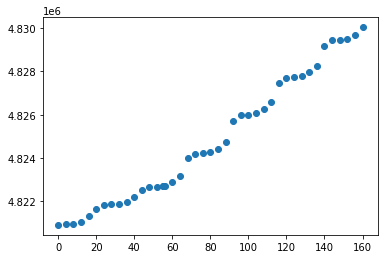

In [13]:
plt.scatter(hours, entries)

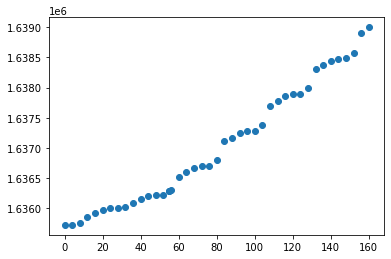

In [14]:
plt.scatter(hours, exits)

In [15]:
entries = get_entries(np.arange(max(hours)))
exits = get_exits(np.arange(max(hours)))

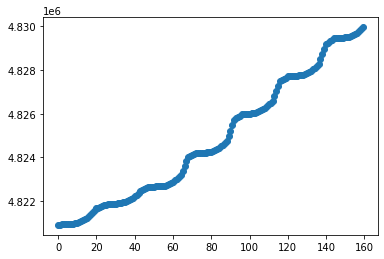

In [16]:
plt.scatter(np.arange(max(hours)), entries)

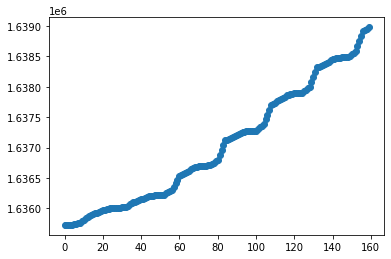

In [17]:
plt.scatter(np.arange(max(hours)), exits)

In [ ]:
# data.to_csv(os.path.join('data', 'tst.csv'), index = False)